## Dynamic Labour Fertility Model

 restart kernal every model you want to run

In [2]:
using Random, Optim, LinearAlgebra, Interpolations, ForwardDiff, Base.Threads
using Plots, Statistics

In [ ]:
using Logging
global_logger(SimpleLogger(stdout, Logging.Error))

# Function to generate a non-linearly spaced grid
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

mutable struct DynLaborFertModel
    # List all 35 fields here
    T::Int
    rho::Float64
    beta_0::Float64
    beta_1::Float64
    eta::Float64
    gamma::Float64
    alpha::Float64
    w::Float64
    tau::Float64
    p_birth::Float64                                     
    r::Float64
    a_max::Float64
    a_min::Float64
    Na::Int 
    k_max::Float64
    Nk::Int
    Nn::Int
    simT::Int
    simN::Int
    a_grid::Vector{Float64}
    k_grid::Vector{Float64}
    n_grid::Vector{Int}
    sol_c::Array{Float64,4}
    sol_h::Array{Float64,4}
    sol_v::Array{Float64,4}
    sim_c::Array{Float64,2}
    sim_h::Array{Float64,2}
    sim_a::Array{Float64,2}
    sim_k::Array{Float64,2}
    sim_n::Array{Int,2}
    sim_a_init::Vector{Float64}
    sim_k_init::Vector{Float64}
    sim_n_init::Vector{Int}
    draws_uniform::Array{Float64,2}
    w_vec::Vector{Float64}
end

# Outer constructor that builds the model
function DynLaborFertModel(; T=10, rho=1/(1.02), beta_0=0.1, beta_1=0.05, eta=-2.0,
                           gamma=2.5, alpha=0.3, w=1.0, tau=0.1, p_birth=0.1, r=0.02,
                           a_max=5.0, a_min=-10.0, Na=50, k_max=20.0, Nk=20, Nn=2,
                           simN=1000, seed=9210)
    simT = T
    a_grid = nonlinspace(a_min, a_max, Na, 1.1)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1)
    n_grid = collect(0:(Nn-1))

    sol_shape = (T, Nn, Na, Nk)
    sol_c = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_n = fill(0, sim_shape)

    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, sim_shape...)

    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)
    sim_n_init = zeros(Int, simN)

    w_vec = fill(w, T)

    return DynLaborFertModel(T, rho, beta_0, beta_1, eta, gamma, alpha, w, tau, p_birth, r,
                              a_max, a_min, Na, k_max, Nk, Nn, simT, simN,
                              a_grid, k_grid, n_grid,
                              sol_c, sol_h, sol_v,
                              sim_c, sim_h, sim_a, sim_k, sim_n,
                              sim_a_init, sim_k_init, sim_n_init,
                              draws_uniform, w_vec)
end


# --------------------------
# Model Solver
# --------------------------

function solve_model!(model::DynLaborFertModel)
    T, Nn, Na, Nk = model.T, model.Nn, model.Na, model.Nk
    a_grid, k_grid, n_grid = model.a_grid, model.k_grid, model.n_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v

    for t in T:-1:1
        println("Processing period t = $t")
        for (i_n, kids) in enumerate(n_grid)
            for (i_a, assets) in enumerate(a_grid)
                for (i_k, capital) in enumerate(k_grid)
                    idx = (t, i_n, i_a, i_k)
                    w = wage_func(model, capital, t)

                    if t == T
                        # =============== LAST PERIOD (UNIVARIATE) ===============
                        f(hours) = obj_last(model, hours, assets, capital, kids)
                        hours_min = max((-assets / w) + 1.0e-5, 0.0)

                        res = optimize(f, hours_min, 24.0, Brent())

                        h_opt = Optim.minimizer(res)
                        cons = cons_last(model, h_opt, capital, assets)
                        
                        sol_h[t, i_n, i_a, i_k] = h_opt
                        sol_c[t, i_n, i_a, i_k] = cons
                        sol_v[idx...] = -Optim.minimum(res)

                    else
                        # =============== EARLIER PERIODS (MULTIVARIATE) ===============

                        # ### CHANGED ###: Use a gradient-based objective
                        obj(x) = neg_value_of_choice(x, model, assets, capital, kids, t)
                        function grad!(storage, x)
                            grad_neg_value_of_choice!(storage, x, model, assets, capital, kids, t)
                        end

                        # Initial guess
                        idx_last = (t+1, i_n, i_a, i_k)
                        init = [sol_c[idx_last...], sol_h[idx_last...]]

                        # Box constraints
                        lb = [1e-6, 0.0]
                        ub = [Inf,   24.0]

                        # ### CHANGED ###: Use Fminbox with LBFGS (or another gradient-based solver)
                        res = optimize(obj, grad!, lb, ub, init,
                                       Fminbox(LBFGS()),
                                       Optim.Options(g_tol=1e-6))

                        # Extract the solution
                        sol_c[idx...] = Optim.minimizer(res)[1]
                        sol_h[idx...] = Optim.minimizer(res)[2]
                        sol_v[idx...] = -Optim.minimum(res)
                    end
                end
            end
        end
    end
    return model
end

# ------------------------------------------------
# Supporting functions (unchanged)
# ------------------------------------------------

@inline function cons_last(model::DynLaborFertModel, h::Float64, capital::Float64, assets::Float64)
    income = wage_func(model, capital, model.T) * h 
    cons = assets + income
    return cons
end

@inline function obj_last(model::DynLaborFertModel, h::Float64, assets::Float64, capital::Float64, kids::Int)
    cons = cons_last(model, h, capital, assets)
    u = util(model, cons, h, kids)
    return -u
end

@inline function util(model::DynLaborFertModel, c, h, kids::Int)
    par = model
    beta = par.beta_0 + par.beta_1 * kids
    return (c^(1.0 + par.eta)) / (1.0 + par.eta) - beta * (h^(1.0 + par.gamma)) / (1.0 + par.gamma)
end

@inline function wage_func(model::DynLaborFertModel, capital::Float64, t::Int)
    par = model  # Extract parameters
    return (1.0 - par.tau) * par.w_vec[t] * (1.0 + par.alpha * capital)
end

function value_of_choice(model::DynLaborFertModel, cons, hours, assets, capital, kids::Int, t::Int)
    par = model
    sol_v = model.sol_v
    a_grid, k_grid = model.a_grid, model.k_grid

    # Penalties (still fine, as they accept Dual too)
    penalty = 0.0
    penalty += (cons < 0.0)  ? cons * 10000.0 : 0.0
    penalty += (hours < 0.0) ? hours * 10000.0 : 0.0

    # Utility
    util_val = util(model, cons, hours, kids)

    # Next period states
    income = wage_func(model, capital, t) * hours
    a_next = (1.0 + par.r) * (assets + income - cons)
    k_next = capital + hours

    # Interpolate next-period value
    kids_next = kids
    V_next_no_birth_data = sol_v[t+1, kids_next+1, :, :]
    interp_no_birth = LinearInterpolation((a_grid, k_grid), V_next_no_birth_data, 
                                          extrapolation_bc=Line())
    V_next_no_birth = interp_no_birth(a_next, k_next)

    # Birth case
    if kids < par.Nn - 1
        V_next_birth_data = sol_v[t+1, kids_next+2, :, :]
        interp_birth = LinearInterpolation((a_grid, k_grid), V_next_birth_data,
                                           extrapolation_bc=Line())
        V_next_birth = interp_birth(a_next, k_next)
    else
        V_next_birth = V_next_no_birth
    end

    EV_next = par.p_birth * V_next_birth + (1 - par.p_birth) * V_next_no_birth
    return util_val + par.rho * EV_next + penalty
end

# ------------------------------------------------
# Gradient-based wrappers
# ------------------------------------------------

@inline function neg_value_of_choice(x, model, assets, capital, kids, t)
    # Return -value_of_choice(...) for minimization
    return -value_of_choice(model, x[1], x[2], assets, capital, kids, t)
end

@inline function grad_neg_value_of_choice!(storage, x, model, assets, capital, kids, t)
    # Automatic differentiation via ForwardDiff
    ForwardDiff.gradient!(
        storage,
        y -> neg_value_of_choice(y, model, assets, capital, kids, t),
        x
    )
end


# --------------------------
# Simulation
# --------------------------

function simulate_model!(model::DynLaborFertModel)
    simN, simT = model.simN, model.simT
    sim_n, sim_a, sim_k, sim_c, sim_h = model.sim_n, model.sim_a, model.sim_k, model.sim_c, model.sim_h
    draws_uniform = model.draws_uniform

    # Precompute interpolation objects
    interp_dict = Dict()
    for t in 1:simT
        for child_idx in 1:model.Nn
            sol_c_slice = model.sol_c[t, child_idx, :, :]
            sol_h_slice = model.sol_h[t, child_idx, :, :]
            interp_dict[(t, child_idx, :c)] = LinearInterpolation((model.a_grid, model.k_grid), sol_c_slice, extrapolation_bc=Line())
            interp_dict[(t, child_idx, :h)] = LinearInterpolation((model.a_grid, model.k_grid), sol_h_slice, extrapolation_bc=Line())
        end
    end

    # Initialize
    for i in 1:simN
        sim_n[i, 1] = model.sim_n_init[i]
        sim_a[i, 1] = model.sim_a_init[i]
        sim_k[i, 1] = model.sim_k_init[i]
    end

    # Simulate
    for i in 1:simN
        for t in 1:simT
            child_idx = sim_n[i, t] + 1
            sim_c[i, t] = interp_dict[(t, child_idx, :c)](sim_a[i, t], sim_k[i, t])
            sim_h[i, t] = interp_dict[(t, child_idx, :h)](sim_a[i, t], sim_k[i, t])
            if t < simT
                income = wage_func(model, sim_k[i, t], t) * sim_h[i, t]
                sim_a[i, t+1] = (1 + model.r) * (sim_a[i, t] + income - sim_c[i, t])
                sim_k[i, t+1] = sim_k[i, t] + sim_h[i, t]
                birth = (draws_uniform[i, t] <= model.p_birth && sim_n[i, t] < model.Nn - 1) ? 1 : 0
                sim_n[i, t+1] = sim_n[i, t] + birth
            end
        end
    end
end



simulate_model! (generic function with 1 method)

In [ ]:
# --------------------------
# Main Routine
# --------------------------
model = DynLaborModel();
@time solve_model!(model);
simulate_model!(model);

Processing period t = 10
Processing period t = 9
Processing period t = 8
Processing period t = 7
Processing period t = 6
Processing period t = 5
Processing period t = 4
Processing period t = 3
Processing period t = 2
Processing period t = 1
 23.420029 seconds (106.05 M allocations: 88.003 GiB, 21.39% gc time, 3.65% compilation time)


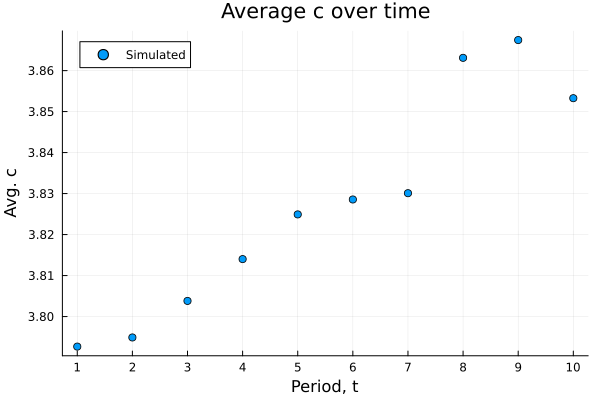

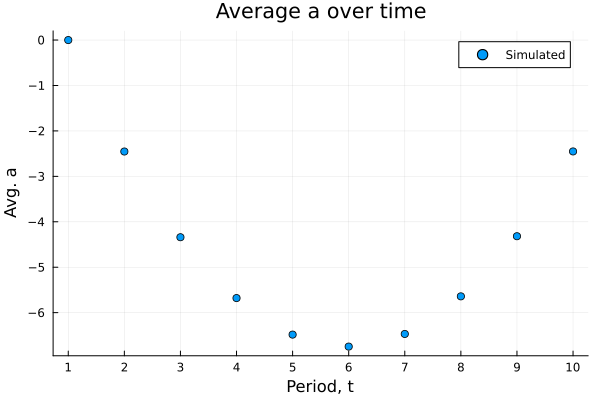

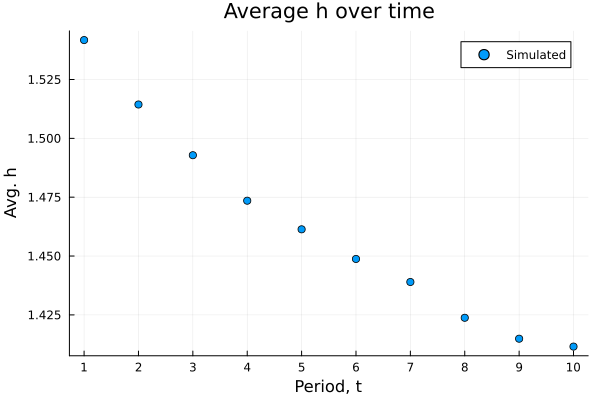

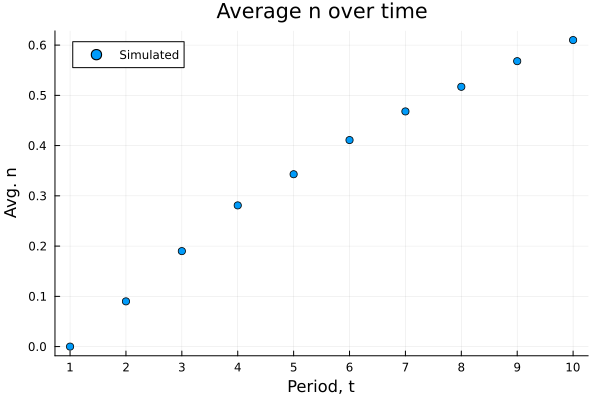

In [7]:
# Create a dictionary for simulation variables.
# Replace `model.sim_c`, `model.sim_a`, etc. with your actual simulation arrays.
sim_dict = Dict(
    "c" => model.sim_c,
    "a" => model.sim_a,
    "h" => model.sim_h,
    "n" => model.sim_n
)

# Define the time periods (assuming simulation is stored with dimensions (simN, simT))
time_periods = 1:model.simT

# Loop over the variables and plot the average value for each period.
for (var, sim_data) in sim_dict
    avg_vals = vec(mean(sim_data, dims=1))  # average over individuals (dimension 1)
    p = scatter(time_periods, avg_vals, label="Simulated",
                xlabel="Period, t",
                ylabel="Avg. $var",
                xticks=time_periods,
                title="Average $var over time")
    display(p)
    # Optionally, save the plot:
    # savefig(p, "avg_$var.png")
end

## Model with transitory and AR1 persistant shocks 
without child

In [1]:
using Logging, NLopt, ForwardDiff, Interpolations
using QuantEcon, FastGaussQuadrature, Random, Plots

global_logger(SimpleLogger(stdout, Logging.Info))

# Function to generate a non-linearly spaced grid
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

# Define the DynLaborModel struct
mutable struct DynLaborModel
    # Core parameters
    T::Int                   # Time horizon
    rho::Float64             # Discount factor
    eta::Float64             # Consumption elasticity
    gamma::Float64           # Labor disutility parameter
    alpha::Float64           # Human capital return parameter
    w::Float64               # Base wage
    tau::Float64             # Tax rate
    r::Float64               # Interest rate

    # Grid parameters
    a_max::Float64           # Max assets
    a_min::Float64           # Min assets
    Na::Int                  # Number of asset grid points
    k_max::Float64           # Max human capital
    Nk::Int                  # Number of human capital grid points

    # Simulation parameters
    simT::Int                # Simulation periods
    simN::Int                # Number of individuals
    a_grid::Vector{Float64}  # Asset grid
    k_grid::Vector{Float64}  # Human capital grid
    sim_z::Array{Float64,2}  # Simulated z values
    sim_t::Array{Float64,2}  # Simulated t values

    # Solution and simulation arrays
    sol_c::Array{Float64,4}  # Consumption: (T, Na, Nk, Nz)
    sol_h::Array{Float64,4}  # Hours: (T, Na, Nk, Nz)
    sol_v::Array{Float64,4}  # Value: (T, Na, Nk, Nz)
    sim_c::Array{Float64,2}  # Simulated consumption
    sim_h::Array{Float64,2}  # Simulated hours
    sim_a::Array{Float64,2}  # Simulated assets
    sim_k::Array{Float64,2}  # Simulated human capital


    # Initial conditions and random draws
    sim_a_init::Vector{Float64}  # Initial assets
    sim_k_init::Vector{Float64}  # Initial human capital
    draws_uniform::Array{Float64,2}  # For employment transitions
    w_vec::Vector{Float64}   # Wage over time

    # New fields for shocks
    Nz::Int                  # Number of grid points for z
    Nt::Int                  # Number of grid points for t
    z_grid::Vector{Float64}  # Grid for permanent shock z
    t_grid::Vector{Float64}  # Grid for transitory shock t
    Pi::Matrix{Float64}      # Transition matrix for z
    sigma_eps::Float64       # Std dev of transitory shock
    sigma_eta::Float64       # Std dev of permanent shock innovation
    rho_z::Float64           # Persistence of permanent shock
    t_weight::Vector{Float64}  # Weights for t quadrature
end

# Constructor
function DynLaborModel(; T=10, rho=1/(1.02), eta=-2.0, gamma=2.5, alpha=0.3, w=1.0, tau=0.1, r=0.02,
                       a_max=10.0, a_min=-5.0, Na=50, k_max=20.0, Nk=20, simN=1000, seed=9210,
                       Nz=5, Nt=5, sigma_eps=0.05, sigma_eta=0.1, rho_z=0.95)
    simT = T

    a_grid = nonlinspace(a_min, a_max, Na, 1.1)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1)

    # Permanent shock using Tauchen method
    mc = tauchen(Nz, rho_z, sigma_eta, 0.0)
    z_grid = collect(mc.state_values)
    Pi = mc.p

    # Transitory shocks via Gauss-Hermite quadrature
    x_gh, w_gh = gausshermite(Nt)
    t_grid = x_gh * sqrt(2) * sigma_eps
    t_weight = w_gh / sqrt(pi)
    t_weight ./= sum(t_weight)

    # Solution arrays with dimensions (T, Na, Nk, Nz)
    sol_shape = (T, Na, Nk, Nz)
    sol_c = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    # Simulation arrays
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_z = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)

    # Initial conditions and random draws
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, Float64, simN, simT)
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    w_vec = fill(w, T)

    return DynLaborModel(T, rho, eta, gamma, alpha, w, tau, r,
                         a_max, a_min, Na, k_max, Nk, simT, simN,
                         a_grid, k_grid, sim_z, sim_t,
                         sol_c, sol_h, sol_v,
                         sim_c, sim_h, sim_a, sim_k,
                         sim_a_init, sim_k_init,
                         draws_uniform, w_vec,
                         Nz, Nt, z_grid, t_grid, Pi,
                         sigma_eps, sigma_eta, rho_z, t_weight)
end

# ------------------------------------------------
# Supporting Functions
# ------------------------------------------------

@inline function cons_last(model::DynLaborModel, h::Float64, capital::Float64, assets::Float64, z::Float64, eps::Float64)
    income = wage_func(model, capital, z, eps, model.T) * h
    cons = assets + income
    return cons
end

@inline function obj_last(model::DynLaborModel, h::Float64, assets::Float64, capital::Float64, z::Float64, eps::Float64)
    cons = cons_last(model, h, capital, assets, z, eps)
    u = util(model, cons, h)
    return -u
end

@inline function util(model::DynLaborModel, c, h)
    par = model
    return (c^(1.0 + par.eta)) / (1.0 + par.eta) - (h^(1.0 + par.gamma)) / (1.0 + par.gamma)
end

@inline function wage_func(model::DynLaborModel, capital::Float64, z::Float64, eps::Float64, t::Int)
    par = model
    return (1.0 - par.tau) * par.w_vec[t] * exp(z + eps) * (1.0 + par.alpha * capital)
end

function value_of_choice(model::DynLaborModel, cons, hours, assets, capital, i_z::Int, t::Int)
    z = model.z_grid[i_z]
    par = model
    a_grid, k_grid = model.a_grid, model.k_grid
    Pi = model.Pi
    Nt, t_grid, t_weight = model.Nt, model.t_grid, model.t_weight

    # Apply penalties if consumption or hours are negative
    penalty = 0.0
    penalty += (cons < 0.0) ? cons * 10000.0 : 0.0
    penalty += (hours < 0.0) ? hours * 10000.0 : 0.0

    # Current period utility
    util_val = util(model, cons, hours)

    # Compute next period states
    income = 0.0
    for m in 1:Nt
        eps = t_grid[m]
        income += t_weight[m] * wage_func(model, capital, z, eps, t) * hours
    end
    a_next = (1.0 + par.r) * (assets + income - cons)
    k_next = capital + hours

    # Expected continuation value
    EV_next = 0.0
    for (i_z_next, _) in enumerate(model.z_grid)
        V_next = 0.0
        for m in 1:Nt
            interp = LinearInterpolation((a_grid, k_grid), model.sol_v[t+1, :, :, i_z_next],
                                         extrapolation_bc=Line())
            V_next += t_weight[m] * interp(a_next, k_next)
        end
        EV_next += Pi[i_z, i_z_next] * V_next
    end

    return util_val + par.rho * EV_next + penalty
end

@inline function neg_value_of_choice(x, model, assets, capital, i_z, t)
    return -value_of_choice(model, x[1], x[2], assets, capital, i_z, t)
end

@inline function grad_neg_value_of_choice!(storage, x, model, assets, capital, i_z, t)
    ForwardDiff.gradient!(
        storage,
        y -> neg_value_of_choice(y, model, assets, capital, i_z, t),
        x
    )
end

# ------------------------------------------------
# NLopt Wrappers for Optimization
# ------------------------------------------------

# One-dimensional (scalar) optimization wrapper using NLopt
function optimize_scalar(f, lb, ub, init)
    opt = Opt(:LN_BOBYQA, 1)
    lower_bounds!(opt, [lb])
    upper_bounds!(opt, [ub])
    xtol_rel!(opt, 1e-6)
    function obj_func(x, grad)
        return f(x[1])
    end
    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, [init])
    return minx[1], minf, ret
end

# Two-dimensional (vector) optimization wrapper using NLopt
function optimize_vector(model, assets, capital, i_z, t, init)
    opt = Opt(:LD_LBFGS, 2)
    lower_bounds!(opt, [1e-6, 0.0])
    # Use NLoptInf() for no upper bound on consumption and 24 for hours
    upper_bounds!(opt, [Inf, 24.0])
    xtol_rel!(opt, 1e-6)
    function obj_func(x, grad)
         if length(grad) > 0
             grad_neg_value_of_choice!(grad, x, model, assets, capital, i_z, t)
         end
         return neg_value_of_choice(x, model, assets, capital, i_z, t)
    end
    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, init)
    return minx, minf, ret
end

# ------------------------------------------------
# Model Solver using NLopt
# ------------------------------------------------

function solve_model!(model::DynLaborModel)
    T, Na, Nk, Nz = model.T, model.Na, model.Nk, model.Nz
    a_grid, k_grid, z_grid = model.a_grid, model.k_grid, model.z_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v
    Nt = model.Nt
    t_grid = model.t_grid
    t_weight = model.t_weight

    for t in T:-1:1
        @info "Processing period t = $t"
        for (i_a, assets) in enumerate(a_grid)
            for (i_k, capital) in enumerate(k_grid)
                for (i_z, z) in enumerate(z_grid)
                    idx = (t, i_a, i_k, i_z)
                    if t == T
                        # Last period: solve for optimal hours via scalar optimization
                        val = 0.0
                        h_expected = 0.0
                        c_expected = 0.0
                        for m in 1:Nt
                            eps = t_grid[m]
                            w_val = wage_func(model, capital, z, eps, t)
                            f(hours) = obj_last(model, hours, assets, capital, z, eps)
                            hours_min = max((-assets / w_val) + 1e-5, 0.0)
                            # Use midpoint as initial guess
                            init_guess = (hours_min + 24.0) / 2
                            h_opt, fval, ret = optimize_scalar(f, hours_min, 24.0, init_guess)
                            cons = cons_last(model, h_opt, capital, assets, z, eps)
                            val += t_weight[m] * util(model, cons, h_opt)
                            h_expected += t_weight[m] * h_opt
                            c_expected += t_weight[m] * cons
                        end
                        sol_v[idx...] = val
                        sol_h[idx...] = h_expected
                        sol_c[idx...] = c_expected
                    else
                        # Earlier periods: solve for both consumption and hours
                        init = [sol_c[t+1, i_a, i_k, i_z], sol_h[t+1, i_a, i_k, i_z]]
                        minx, minf, ret = optimize_vector(model, assets, capital, i_z, t, init)
                        sol_c[idx...] = minx[1]
                        sol_h[idx...] = minx[2]
                        sol_v[idx...] = -minf
                    end
                end
            end
        end
    end
    return model
end

# --------------------------
# Simulation
# --------------------------
  
function simulate_model!(model::DynLaborModel)
    simN, simT = model.simN, model.simT
    Nz = model.Nz

    # Build interpolation objects for policy functions.
    # For each period and each permanent shock grid index, create an interpolant
    # for consumption (:c) and hours (:h) based on the asset and human capital grids.
    interp_dict = Dict{Tuple{Int,Int,Symbol}, Any}()
    for t in 1:simT
        for iz in 1:Nz
            sol_c_slice = model.sol_c[t, :, :, iz]
            sol_h_slice = model.sol_h[t, :, :, iz]
            interp_dict[(t, iz, :c)] = LinearInterpolation((model.a_grid, model.k_grid),
                                                           sol_c_slice,
                                                           extrapolation_bc=Line())
            interp_dict[(t, iz, :h)] = LinearInterpolation((model.a_grid, model.k_grid),
                                                           sol_h_slice,
                                                           extrapolation_bc=Line())
        end
    end

    # Initialize simulation arrays for assets, human capital, and permanent shock.
    for i in 1:simN
        model.sim_a[i, 1] = model.sim_a_init[i]
        model.sim_k[i, 1] = model.sim_k_init[i]
        # Initialize permanent shock at period 1 (using the median grid index)
        model.sim_z[i, 1] = model.z_grid[ceil(Int, Nz/2)]
    end

    # Loop over individuals to simulate their paths.
    for i in 1:simN
        # We keep track of the current permanent shock index (starting at the median)
        current_z_idx = ceil(Int, Nz/2)
        for t in 1:simT
            # Retrieve interpolation objects for period t and current permanent shock.
            itp_c = interp_dict[(t, current_z_idx, :c)]
            itp_h = interp_dict[(t, current_z_idx, :h)]
            
            # Evaluate policy functions at current state.
            a_current = model.sim_a[i, t]
            k_current = model.sim_k[i, t]
            model.sim_c[i, t] = itp_c(a_current, k_current)
            model.sim_h[i, t] = itp_h(a_current, k_current)
            
            # Draw the transitory shock (ε ~ N(0, σₑ²)) and store it.
            eps = randn() * model.sigma_eps
            model.sim_t[i, t] = eps
            
            # Compute income using the wage function.
            # (Permanent shock is given by model.sim_z[i, t], transitory shock is eps.)
            income = wage_func(model, k_current, model.sim_z[i, t], eps, t) * model.sim_h[i, t]
            
            # Update states for next period if not at the final simulation period.
            if t < simT
                # Update assets: new asset = (1 + r) * (current assets + income - consumption)
                model.sim_a[i, t+1] = (1 + model.r) * (a_current + income - model.sim_c[i, t])
                # Update human capital: accumulate hours worked.
                model.sim_k[i, t+1] = k_current + model.sim_h[i, t]
                
                # Update the permanent shock state using the transition matrix.
                # Retrieve the probability vector for the current shock state.
                prob_vec = model.Pi[current_z_idx, :]
                u = rand()  # uniform random draw between 0 and 1
                cumulative = cumsum(prob_vec)
                new_z_idx = findfirst(x -> u <= x, cumulative)
                new_z_idx = isnothing(new_z_idx) ? Nz : new_z_idx
                current_z_idx = new_z_idx
                model.sim_z[i, t+1] = model.z_grid[current_z_idx]
            end
        end
    end

    return model
end



simulate_model! (generic function with 1 method)

In [2]:
model = DynLaborModel();
@time solve_model!(model);
simulate_model!(model);

┌ Info: Processing period t = 10
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:248
┌ Info: Processing period t = 9
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:248
┌ Info: Processing period t = 8
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:248
┌ Info: Processing period t = 7
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:248
┌ Info: Processing period t = 6
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:248
┌ Info: Processing period t = 5
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df

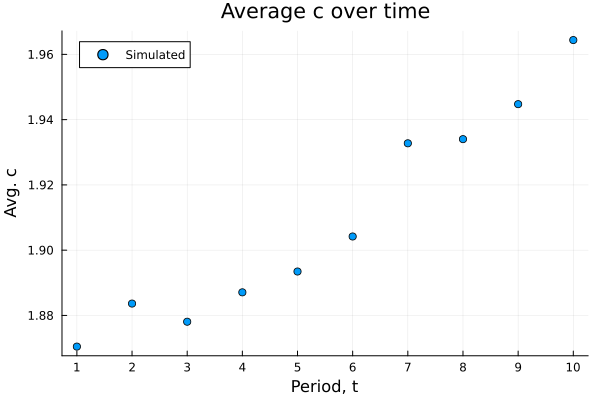

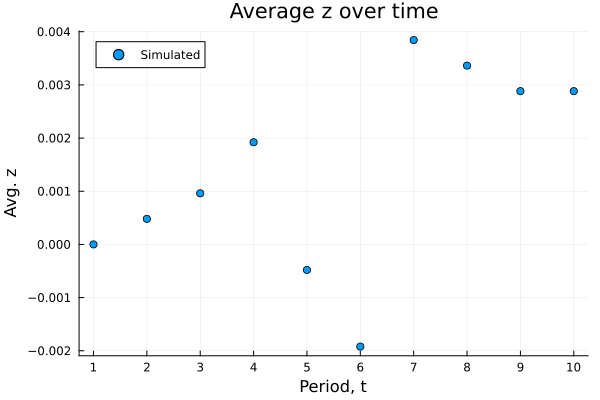

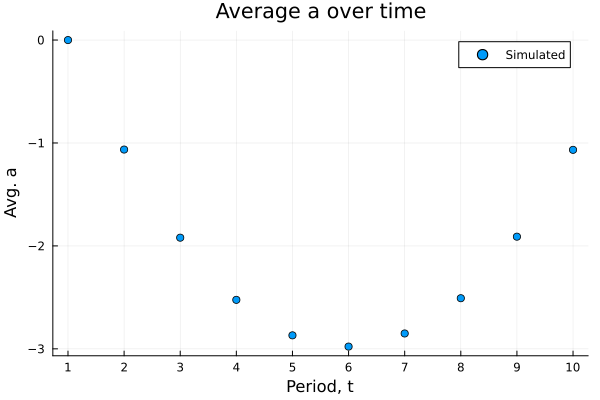

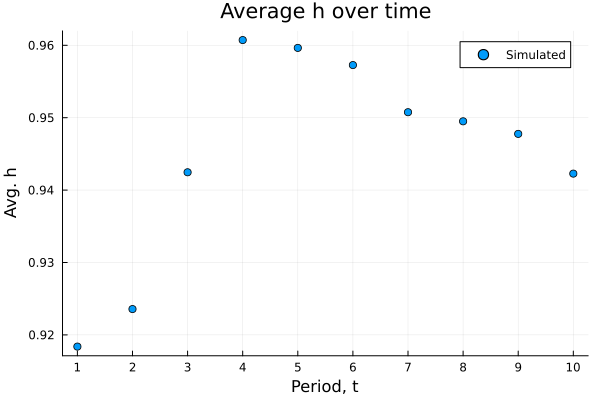

In [3]:
# Create a dictionary for simulation variables.
# Replace `model.sim_c`, `model.sim_a`, etc. with your actual simulation arrays.
sim_dict = Dict(
    "c" => model.sim_c,
    "a" => model.sim_a,
    "h" => model.sim_h,
    "z" => model.sim_z
)

# Define the time periods (assuming simulation is stored with dimensions (simN, simT))
time_periods = 1:model.simT

# Loop over the variables and plot the average value for each period.
for (var, sim_data) in sim_dict
    avg_vals = vec(mean(sim_data, dims=1))  # average over individuals (dimension 1)
    p = scatter(time_periods, avg_vals, label="Simulated",
                xlabel="Period, t",
                ylabel="Avg. $var",
                xticks=time_periods,
                title="Average $var over time")
    display(p)
    # Optionally, save the plot:
    # savefig(p, "avg_$var.png")
end

## Model with transitory and AR1 persistant shocks with unemployment shock

In [52]:

using Logging, NLopt, ForwardDiff, Interpolations
using QuantEcon, FastGaussQuadrature, Random, Plots, StatsBase
global_logger(SimpleLogger(stdout, Logging.Info))

# Function to generate a non-linearly spaced grid
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end


mutable struct DynLaborModel
    # Core parameters
    T::Int                   # Time horizon
    rho::Float64             # Discount factor
    eta::Float64             # Consumption elasticity
    gamma::Float64           # Labor disutility parameter
    alpha::Float64           # Human capital return parameter
    w::Float64               # Base wage
    tau::Float64             # Tax rate
    r::Float64               # Interest rate
    p::Float64               # unemployment probibility
    B::Float64               # unemployment benefits

    # Grid parameters
    a_max::Float64           # Max assets
    a_min::Float64           # Min assets
    Na::Int                  # Number of asset grid points
    k_max::Float64           # Max human capital
    Nk::Int                  # Number of human capital grid points
    Ns::Int                  #unemployment states 

    # Simulation parameters
    simT::Int                # Simulation periods
    simN::Int                # Number of individuals
    a_grid::Vector{Float64}  # Asset grid
    k_grid::Vector{Float64}  # Human capital grid
    s_grid::Vector{Int}      # Employment status grid
    sim_z::Array{Float64,2}  # Simulated z values
    sim_t::Array{Float64,2}  # Simulated t values
    #sim_s::Array{Int,2}  # Employment state for each person and time

    # Solution and simulation arrays
    sol_c::Array{Float64,5}  # Consumption: (T, Na, Nk, Nz, Ns)
    sol_h::Array{Float64,5}  # Hours: (T, Nemp, Na, Nk)
    sol_v::Array{Float64,5}  # Value: (T, Nemp, Na, Nk)
    sim_c::Array{Float64,2}  # Simulated consumption
    sim_h::Array{Float64,2}  # Simulated hours
    sim_a::Array{Float64,2}  # Simulated assets
    sim_k::Array{Float64,2}  # Simulated human capital

    # Initial conditions and random draws
    sim_a_init::Vector{Float64}  # Initial assets
    sim_k_init::Vector{Float64}  # Initial human capital
    draws_uniform::Array{Float64,2}  # For employment transitions
    w_vec::Vector{Float64}   # Wage over time

    # New fields for shocks
    Nz::Int                  # Number of grid points for z
    Nt::Int                  # Number of grid points for t
    z_grid::Vector{Float64}  # Grid for permanent shock z
    t_grid::Vector{Float64}  # Grid for transitory shock t
    Pi::Matrix{Float64}      # Transition matrix for z
    sigma_eps::Float64       # Std dev of transitory shock
    sigma_eta::Float64       # Std dev of permanent shock innovation
    rho_z::Float64           # Persistence of permanent shock
    t_weight::Vector{Float64}  # Weights for t quadrature
end

# Constructor
function DynLaborModel(; T=10, rho=1/1.02, eta=-2.0, gamma=2.5, alpha=0.3, w=1.0, 
                        tau=0.1, r=0.02, p=0.05, B=0.2,
                        a_max=10.0, a_min=-5.0, Na=50, k_max=20.0, Nk=20, Ns=2, 
                        simN=1000, seed=9210,
                        Nz=5, Nt=5, sigma_eps=0.05, sigma_eta=0.1, rho_z=0.95)
    simT = T

    a_grid = nonlinspace(a_min, a_max, Na, 1.1)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1)
    s_grid = collect(1:Ns)  # Employment status grid

    # Permanent shock (z) using Tauchen method
    mc = tauchen(Nz, rho_z, sigma_eta, 0.0)
    z_grid = collect(mc.state_values)   # Grid for permanent shocks
    Pi = mc.p                  # Transition matrix
    
    x_gh, w_gh = gausshermite(Nt)
    t_grid = x_gh * sqrt(2) * sigma_eps  # Nodes for eps ~ N(0, sigma_eps^2)
    t_weight = w_gh / sqrt(pi)             # Weights
    t_weight ./= sum(t_weight)             # Normalize weights (optional, usually sums to 1)

    # Solution arrays with employment status (Nemp=2: employed/unemployed)

    sol_shape = (T, Na, Nk, Nz, Ns)
    sol_c = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)

    # Simulation arrays
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_z = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)
    #sim_s = fill(1, simN, simT)  # Start all employed

    # Initial conditions and random draws
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, Float64, simN, simT)
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    w_vec = fill(w, T)

    return DynLaborModel(
        T, rho, eta, gamma, alpha, w, tau, r, p, B,
        a_max, a_min, Na, k_max, Nk, Ns,
        simT, simN, a_grid, k_grid, s_grid, sim_z, sim_t,
        sol_c, sol_h, sol_v,
        sim_c, sim_h, sim_a, sim_k,
        sim_a_init, sim_k_init, draws_uniform, w_vec,
        Nz, Nt, z_grid, t_grid, Pi, sigma_eps, sigma_eta, rho_z, t_weight
    )
end

# ------------------------------------------------
# Supporting Functions
# ------------------------------------------------

@inline function cons_last(model::DynLaborModel, h::Float64, capital::Float64, assets::Float64, z::Float64, eps::Float64)
    income = wage_func(model, capital, z, eps, model.T) * h
    cons = assets + income
    return cons
end

@inline function obj_last(model::DynLaborModel, h::Float64, assets::Float64, capital::Float64, z::Float64, eps::Float64)
    cons = cons_last(model, h, capital, assets, z, eps)
    u = util(model, cons, h)
    return -u
end

@inline function util(model::DynLaborModel, c, h)
    par = model
    return (c^(1.0 + par.eta)) / (1.0 + par.eta) - (h^(1.0 + par.gamma)) / (1.0 + par.gamma)
end

@inline function wage_func(model::DynLaborModel, capital::Float64, z::Float64, eps::Float64, t::Int)
    par = model
    return (1.0 - par.tau) * par.w_vec[t] * exp(z + eps) * (1.0 + par.alpha * capital)
end

function value_of_choice(model::DynLaborModel, cons, hours, assets, capital, i_z::Int, t::Int, s::Int)
    z = model.z_grid[i_z]
    par = model
    a_grid, k_grid = model.a_grid, model.k_grid
    Pi = model.Pi
    Nt, t_grid, t_weight = model.Nt, model.t_grid, model.t_weight

    # Apply penalties if consumption or hours are negative
    penalty = 0.0
    penalty += (cons < 0.0) ? cons * 10000.0 : 0.0
    penalty += (hours < 0.0) ? hours * 10000.0 : 0.0

    # Current period utility
    util_val = util(model, cons, hours)

    # Compute next period states
    income = 0.0
    if s == 2 
        income = model.B
    else
        for m in 1:Nt
            eps = t_grid[m]
            income += t_weight[m] * wage_func(model, capital, z, eps, t) * hours
        end
    end

    a_next = (1.0 + par.r) * assets + income - cons
    k_next = capital + hours

    # Expected continuation value
    EV_next = 0.0
    for (i_z_next, _) in enumerate(model.z_grid)
        V_next = 0.0
        interp = LinearInterpolation((a_grid, k_grid), model.sol_v[t+1, :, :, i_z_next, 1],
                                         extrapolation_bc=Line())
        V_next = interp(a_next, k_next)
        EV_next += Pi[i_z, i_z_next] * V_next
    end

    interp_unemp = LinearInterpolation((a_grid, k_grid), model.sol_v[t+1, :, :, i_z, 2],
                                               extrapolation_bc=Line())
    EV_u = interp_unemp(a_next, capital)

    return util_val + par.rho * ((1-model.p) * EV_next + model.p * EV_u) + penalty
end




@inline function neg_value_of_choice(x, model, assets, capital, i_z, t, s)
    return -value_of_choice(model, x[1], x[2], assets, capital, i_z, t , s)
end

@inline function grad_neg_value_of_choice!(storage, x, model, assets, capital, i_z, t, s)
    ForwardDiff.gradient!(
        storage,
        y -> neg_value_of_choice(y, model, assets, capital, i_z, t, s),
        x
    )
end

# ------------------------------------------------
# NLopt Wrappers for Optimization
# ------------------------------------------------

# One-dimensional (scalar) optimization wrapper using NLopt
function optimize_scalar(f, lb, ub, init)
    opt = Opt(:LN_BOBYQA, 1)
    lower_bounds!(opt, [lb])
    upper_bounds!(opt, [ub])
    xtol_rel!(opt, 1e-6)
    function obj_func(x, grad)
        return f(x[1])
    end
    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, [init])
    return minx[1], minf, ret
end

# Two-dimensional (vector) optimization wrapper using NLopt
function optimize_vector(model, assets, capital, i_z, t, s, init)
    opt = Opt(:LD_LBFGS, 2)
    lower_bounds!(opt, [1e-6, 0.0])
    upper_bounds!(opt, [Inf, 24.0])
    xtol_rel!(opt, 1e-6)

    function obj_func(x, grad)
        if length(grad) > 0
            grad_neg_value_of_choice!(grad, x, model, assets, capital, i_z, t, s)
        end
        return neg_value_of_choice(x, model, assets, capital, i_z, t, s)
    end

    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, init)
    return minx, minf, ret
end

function optimize_consumption_only(model, assets, capital, i_z, t, s, init_c)
    opt = Opt(:LN_BOBYQA, 1)
    lower_bounds!(opt, [1e-6])  # Consumption must be positive
    upper_bounds!(opt, [Inf])
    xtol_rel!(opt, 1e-6)

    # Define objective function: only optimizing over consumption
    function obj_func(x, grad)
        c = x[1]
        return -value_of_choice(model, c, 0.0, assets, capital, i_z, t, s)
    end

    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, [init_c])

    return minx[1], minf, ret  # Return optimal consumption, value, status
end

# --------------------------
# Model Solver
# --------------------------

function solve_model!(model::DynLaborModel)
    T, Na, Nk, Nz, Ns = model.T, model.Na, model.Nk, model.Nz, model.Ns
    a_grid, k_grid, z_grid, s_grid = model.a_grid, model.k_grid, model.z_grid, model.s_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v
    Nt = model.Nt
    t_grid = model.t_grid
    t_weight = model.t_weight

    for t in T:-1:1
        @info "Processing period t = $t"
        for (i_a, assets) in enumerate(a_grid)
            for (i_k, capital) in enumerate(k_grid)
                for (i_z, z) in enumerate(z_grid)
                    for(i_s, s) in enumerate(s_grid)
                        idx = (t, i_a, i_k, i_z, i_s)
                        if t == T
                            # Last period: solve for optimal hours via scalar optimization
                            if s == 1
                                val = 0.0
                                h_expected = 0.0
                                c_expected = 0.0
                                for m in 1:Nt
                                    eps = t_grid[m]
                                    w_val = wage_func(model, capital, z, eps, t)
                                    f(hours) = obj_last(model, hours, assets, capital, z, eps)
                                    hours_min = max((-assets / w_val) + 1e-5, 0.0)
                                    # Use midpoint as initial guess
                                    init_guess = (hours_min + 24.0) / 2
                                    h_opt, fval, ret = optimize_scalar(f, hours_min, 24.0, init_guess)
                                    cons = cons_last(model, h_opt, capital, assets, z, eps)
                                    val += t_weight[m] * util(model, cons, h_opt)
                                    h_expected += t_weight[m] * h_opt
                                    c_expected += t_weight[m] * cons
                                end
                                sol_v[idx...] = val
                                sol_h[idx...] = h_expected
                                sol_c[idx...] = c_expected
                            else
                                h = 0.0
                                cons = assets + model.B
                                sol_v[idx...] = util(model, cons, h)
                                sol_h[idx...] = h
                                sol_c[idx...] = cons
                            end
                        else
                            idx_next = (t+1, i_a, i_k, i_z, i_s)
                            if s == 1
                                # Earlier periods: solve for both consumption and hours
                                init = [sol_c[idx_next...], sol_h[idx_next...]]
                                minx, minf, ret = optimize_vector(model, assets, capital, i_z, t, s, init)
                                sol_c[idx...] = minx[1]
                                sol_h[idx...] = minx[2]
                                sol_v[idx...] = -minf

                            else 
                                init = sol_c[idx_next...]
                                cons, fval, ret = optimize_consumption_only(model, assets, capital, i_z, t, s, init)
                                sol_c[idx...] = cons
                                sol_h[idx...] = 0.0
                                sol_v[idx...] = -fval
                            end
                        end
                    end
                end
            end
        end
    end
    return model
end


# --------------------------
# Simulation
# --------------------------
  
# Helper function to find the index of the grid point closest to a value
function findnearest(grid::Vector{Float64}, val::Float64)
    return argmin(abs.(grid .- val))
end

function simulate_model!(model::DynLaborModel)
    # Extract dimensions and grids
    simN, simT = model.simN, model.simT
    Nz, Ns = model.Nz, model.Ns
    a_grid   = model.a_grid
    k_grid   = model.k_grid
    s_grid   = model.s_grid   # For employment states, e.g. [1, 2]
    Pi       = model.Pi
    r        = model.r
    B        = model.B
    sigma_eps = model.sigma_eps
    t_grid   = model.t_grid
    t_weight = model.t_weight

    # Precompute interpolation objects for each period, permanent shock state, and employment state
    interp_dict = Dict{Tuple{Int,Int,Int,Symbol}, Any}()
    for t in 1:simT
        for i_z in 1:Nz
            for s in s_grid
                sol_c_slice = model.sol_c[t, :, :, i_z, s]
                sol_h_slice = model.sol_h[t, :, :, i_z, s]
                interp_dict[(t, i_z, s, :c)] = LinearInterpolation((a_grid, k_grid),
                                                                    sol_c_slice,
                                                                    extrapolation_bc=Line())
                interp_dict[(t, i_z, s, :h)] = LinearInterpolation((a_grid, k_grid),
                                                                    sol_h_slice,
                                                                    extrapolation_bc=Line())
            end
        end
    end

    # Initialize simulation arrays for assets, human capital, permanent shock, and transitory shock
    for i in 1:simN
        model.sim_a[i, 1] = model.sim_a_init[i]
        model.sim_k[i, 1] = model.sim_k_init[i]
        # Initialize permanent shock at period 1 at the median grid value.
        model.sim_z[i, 1] = model.z_grid[ceil(Int, Nz/2)]
        model.sim_t[i, 1] = 0.0  # Set initial transitory shock to 0 (or you can draw if desired)
    end

    # Initialize employment state in a local array (1 = employed, 2 = unemployed)
    sim_s = fill(1, simN, simT)  # All start employed

    # Main simulation loop over individuals and time periods
    for i in 1:simN
        for t in 1:simT
            # Retrieve current state variables
            a = model.sim_a[i, t]
            k = model.sim_k[i, t]
            i_z = findnearest(model.z_grid, model.sim_z[i, t])
            s = sim_s[i, t]  # employment state

            # Evaluate Policy Functions using interpolation objects
            interp_c = interp_dict[(t, i_z, s, :c)]
            interp_h = interp_dict[(t, i_z, s, :h)]
            c = interp_c(a, k)
            h = interp_h(a, k)
            model.sim_c[i, t] = c
            model.sim_h[i, t] = h

            # Draw transitory shock ε ~ N(0, σ²)
            ε = randn() * sigma_eps
            model.sim_t[i, t] = ε

            # Compute income: if unemployed (s==2), income is benefit; else, wage income.
            if s == 2
                income = B
                h = 0.0  # no labor if unemployed
            else
                income = wage_func(model, k, model.z_grid[i_z], ε, t) * h
            end

            # Update next period states if not at the final simulation period
            if t < simT
                a_next = (1 + r) * a + income - c
                k_next = k + h
                model.sim_a[i, t+1] = a_next
                model.sim_k[i, t+1] = k_next

                # Evolve the permanent shock using Tauchen's transition matrix
                prob_vec = Pi[i_z, :]
                new_index = sample(1:Nz, Weights(prob_vec))
                model.sim_z[i, t+1] = model.z_grid[new_index]

                # Update employment state:
                # If employed, with probability p become unemployed; if unemployed, recover with probability (1-p)
                u = rand()
                new_s = s == 1 ? (u < model.p ? 2 : 1) : (u < (1 - model.p) ? 1 : 2)
                sim_s[i, t+1] = new_s
            end
        end
    end

    # Return both the model and the simulated employment states.
    return model, sim_s
end

simulate_model! (generic function with 1 method)

In [57]:
model = DynLaborModel();
@time solve_model!(model);
simulate_model!(model);

┌ Info: Processing period t = 10
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:285
┌ Info: Processing period t = 9
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:285
┌ Info: Processing period t = 8
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:285
┌ Info: Processing period t = 7
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:285
┌ Info: Processing period t = 6
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:285
┌ Info: Processing period t = 5
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df

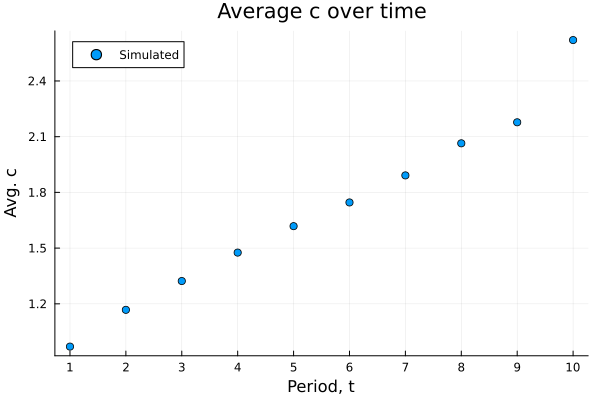

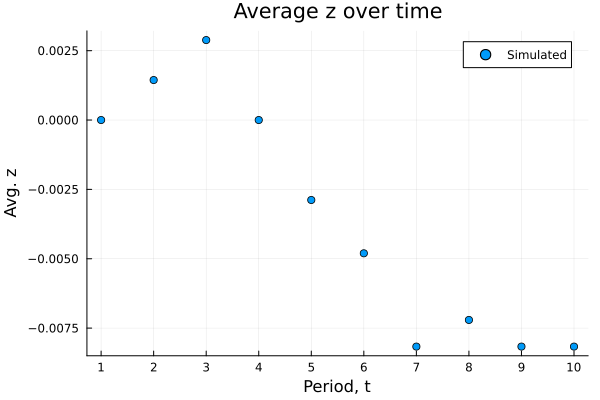

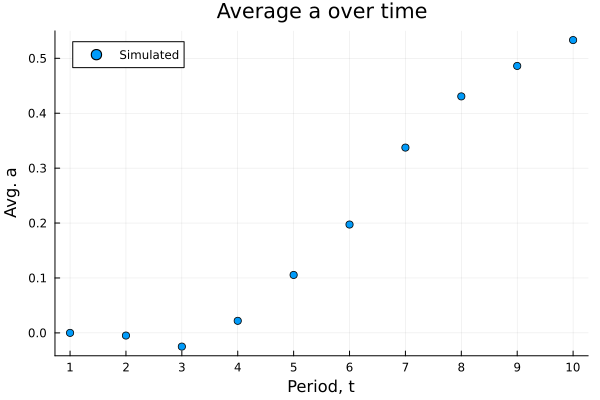

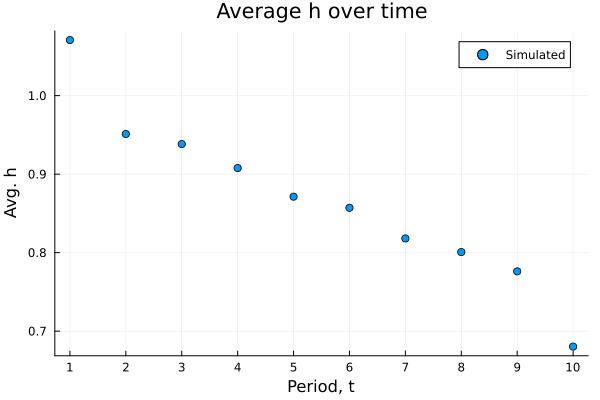

In [58]:
# Create a dictionary for simulation variables.
# Replace `model.sim_c`, `model.sim_a`, etc. with your actual simulation arrays.
sim_dict = Dict(
    "c" => model.sim_c,
    "a" => model.sim_a,
    "h" => model.sim_h,
    "z" => model.sim_z
)

# Define the time periods (assuming simulation is stored with dimensions (simN, simT))
time_periods = 1:model.simT

# Loop over the variables and plot the average value for each period.
for (var, sim_data) in sim_dict
    avg_vals = vec(mean(sim_data, dims=1))  # average over individuals (dimension 1)
    p = scatter(time_periods, avg_vals, label="Simulated",
                xlabel="Period, t",
                ylabel="Avg. $var",
                xticks=time_periods,
                title="Average $var over time")
    display(p)
    # Optionally, save the plot:
    # savefig(p, "avg_$var.png")
end

# college descicion 

#### Initial Decision ($t = 0$)


$$
V_0(X, I) = \max \left\{ \mathbb{E} \left[ V^E\right], \mathbb{E} \left[ V^W \right] \right\}
$$

#### College ($s_t = E$)

$$
V^E _t(E, A_t, k_t, z_t, \epsilon_t) = \max_{c_t} \left\{ \frac{c_t^{1+\eta}}{1+\eta} - \kappa_X + \beta \mathbb{E} \left[ V^W _{t+1}(s_{t+1}, e, A_{t+1}, k_{t+1}\, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r)(A_t - c_t - \tau) - \it{college cost}
$$

$$
k_{t+1} = k_t + h_t^E
$$



#### Labor Market

1. Employed 

$$
V^W _t(W, e, A_t, k_t, 0) = \max_{c_t, h_t} \left\{ \frac{c_t^{1+\eta}}{1+\eta} - \frac{h_t^{1+\gamma}}{1+\gamma} + \beta \mathbb{E} \left[ V^W _{t+1}(W, e, A_{t+1}, k_{t+1}, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r)(A_t + (1 - \tau_{\text{tax}}) w_t h_t - c_t)
$$

$$
w_t = w_0(e)(1 + \alpha k_t) \exp(z_t + \epsilon_t)
$$

$$
k_{t+1} = k_t + h_t
$$

2. Unemployed

$$
V^U _t(W, e, A_t, k_t, 1) = \max_{c_t, h_t} \left\{ \frac{c_t^{1+\eta}}{1+\eta} + \beta \mathbb{E} \left[ V_{t+1}(W, e, A_{t+1}, k_{t+1}, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r)(A_t + b - c_t)
$$

$$
k_{t+1} = k_t
$$


3. Final equation

$$
V(s_t, e, A_t, k_t) = \max_{c_t, h_t} \left\{ u(c_t, h_t) + \beta \left[ (1 - \delta_t) V^W_{t+1}(W, e, A_{t+1}, k_{t+1}) + \delta_t V^U_{t+1}(W, e, A_{t+1}, k_{t+1}) \right]\right\}
$$


#### Shocks

$$
z_{t+1} = \phi z_t + \eta_{t+1}, \quad \eta_{t+1} \sim N(0, \sigma_\eta^2)
$$

$$
\epsilon_t \sim N(0, \sigma_\epsilon^2)
$$

$$
\delta_t \sim \text{Bernoulli}(p)
$$

In [1]:
using Logging, NLopt, ForwardDiff, Interpolations
using QuantEcon, FastGaussQuadrature, Random, Plots
global_logger(SimpleLogger(stdout, Logging.Info))

# Suppose we already have some nonlinspace, util, wage_func, etc. from your code
# We'll define a new constructor to hold the extra college fields and arrays.

mutable struct DynLaborCollegeModel
    # Original parameters
    T::Int
    rho::Float64
    eta::Float64
    gamma::Float64
    alpha::Float64
    w::Float64
    tau::Float64
    r::Float64
    p::Float64
    B::Float64

    # Grids
    a_max::Float64
    a_min::Float64
    Na::Int
    k_max::Float64
    Nk::Int
    Ns::Int  # unemployment states

    # Simulation
    simT::Int
    simN::Int
    a_grid::Vector{Float64}
    k_grid::Vector{Float64}
    s_grid::Vector{Int}
    sim_z::Array{Float64,2}
    sim_t::Array{Float64,2}
    

    # Original solution arrays
    sol_c_work::Array{Float64,5}  # (t, a, k, z, s)
    sol_h_work::Array{Float64,5}  # (t, a, k, z, s)
    sol_v_work::Array{Float64,5}  # (t, a, k, z, s)

    # Arrays for the college path
    # We'll also keep track of s dimension here, so the model sees the shock
    sol_c_college::Array{Float64,5}  # (t, a, k, z, s)
    sol_h_college::Array{Float64,5}  # (t, a, k, z, s)
    sol_v_college::Array{Float64,5}  # (t, a, k, z, s)

    # Simulation arrays
    sim_c::Array{Float64,2}
    sim_h::Array{Float64,2}
    sim_a::Array{Float64,2}
    sim_k::Array{Float64,2}

    sim_a_init::Vector{Float64}
    sim_k_init::Vector{Float64}
    draws_uniform::Array{Float64,2}
    w_vec::Vector{Float64}

    # Shock structure
    Nz::Int
    Nt::Int
    z_grid::Vector{Float64}
    t_grid::Vector{Float64}
    Pi::Matrix{Float64}
    sigma_eps::Float64
    sigma_eta::Float64
    rho_z::Float64
    t_weight::Vector{Float64}

    # ============= New fields for college =============
    t1::Int
    college_cost::Float64
    college_boost::Float64
end

# Constructor with defaults for the new parameters
function DynLaborCollegeModel(; 
    T=10, rho=0.98, eta=-2.0, gamma=2.0, alpha=0.3, w=1.0, 
    tau=0.1, r=0.03, p=0.10, B=0.5,
    a_max=10.0, a_min=-5.0, Na=50, k_max=20.0, Nk=20, Ns=2, 
    simN=1000, seed=9210,
    Nz=5, Nt=5, sigma_eps=0.05, sigma_eta=0.1, rho_z=0.95,
    # College parameters
    t1=2,
    college_cost=2.0,
    college_boost=1.5,
)
    simT = T

    # Example of building a_grid, k_grid, etc.
    a_grid = range(a_min, a_max, length=Na)
    k_grid = range(0, k_max, length=Nk)
    s_grid = collect(1:Ns)

   
    # Permanent shock (z) using Tauchen method
    mc = tauchen(Nz, rho_z, sigma_eta, 0.0)
    z_grid = collect(mc.state_values)   # Grid for permanent shocks
    Pi = mc.p                  # Transition matrix
    
    x_gh, w_gh = gausshermite(Nt)
    t_grid = x_gh * sqrt(2) * sigma_eps  # Nodes for eps ~ N(0, sigma_eps^2)
    t_weight = w_gh / sqrt(pi)             # Weights
    t_weight ./= sum(t_weight)             # Normalize weights (optional, usually sums to 1)

    sol_shape = (T, Na, Nk, Nz, Ns)
    sol_c_work = fill(NaN, sol_shape)
    sol_h_work = fill(NaN, sol_shape)
    sol_v_work = fill(NaN, sol_shape)

    # For the college path, keep the same shape so we can track s as well
    sol_c_college = fill(NaN, sol_shape)
    sol_h_college = fill(NaN, sol_shape)
    sol_v_college = fill(NaN, sol_shape)

    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)
    sim_z = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)

    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, Float64, simN, simT)
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    w_vec = fill(w, T)
    


    return DynLaborCollegeModel(
    # Group 1: Original parameters
    T, rho, eta, gamma, alpha, w, tau, r, p, B,
    # Group 2: Grids
    a_max, a_min, Na, k_max, Nk, Ns,
    # Group 3: Simulation
    simT, simN, a_grid, k_grid, s_grid, sim_z, sim_t,
    # Group 4: Original solution arrays (work path)
    sol_c_work, sol_h_work, sol_v_work,
    # Group 5: College solution arrays
    sol_c_college, sol_h_college, sol_v_college,
    # Group 6: Simulation arrays
    sim_c, sim_h, sim_a, sim_k, sim_a_init, sim_k_init, draws_uniform, w_vec,
    # Group 7: Shock structure
    Nz, Nt, z_grid, t_grid, Pi, sigma_eps, sigma_eta, rho_z, t_weight,
    # Group 8: New fields for college
    t1, college_cost, college_boost
)
end



function solve_working_model!(model::DynLaborCollegeModel, start_period::Int = 1, 
    target_c = model.sol_c_work, target_h = model.sol_h_work, target_v = model.sol_v_work)

    T, Na, Nk, Nz, Ns = model.T, model.Na, model.Nk, model.Nz, model.Ns
    a_grid, k_grid, z_grid, s_grid = model.a_grid, model.k_grid, model.z_grid, model.s_grid
    sol_c, sol_h, sol_v = target_c, target_h, target_v  # Use the target arrays
    Nt = model.Nt
    t_grid = model.t_grid
    t_weight = model.t_weight

    for t in T:-1:start_period  # Adjusted to respect start_period
        @info "Processing period t = $t"
        for (i_a, assets) in enumerate(a_grid)
            for (i_k, capital) in enumerate(k_grid)
                for (i_z, z) in enumerate(z_grid)
                    for (i_s, s) in enumerate(s_grid)
                        idx = (t, i_a, i_k, i_z, i_s)
                        if t == T
                            if s == 1
                                val = 0.0
                                h_expected = 0.0
                                c_expected = 0.0
                                for m in 1:Nt
                                    eps = t_grid[m]
                                    w_val = wage_func(model, capital, z, eps, t)
                                    f(hours) = obj_last(model, hours, assets, capital, z, eps)
                                    hours_min = max((-assets / w_val) + 1e-5, 0.0)
                                    init_guess = (hours_min + 24.0) / 2
                                    h_opt, fval, ret = optimize_scalar(f, hours_min, 24.0, init_guess)
                                    cons = cons_last(model, h_opt, capital, assets, z, eps)
                                    val += t_weight[m] * util(model, cons, h_opt)
                                    h_expected += t_weight[m] * h_opt
                                    c_expected += t_weight[m] * cons
                                end
                                sol_v[idx...] = val
                                sol_h[idx...] = h_expected
                                sol_c[idx...] = c_expected
                            else
                                h = 0.0
                                cons = assets + model.B
                                sol_v[idx...] = util(model, cons, h)
                                sol_h[idx...] = h
                                sol_c[idx...] = cons
                            end
                        else
                            idx_next = (t+1, i_a, i_k, i_z, i_s)
                            if s == 1
                                init = [sol_c[idx_next...], sol_h[idx_next...]]
                                minx, minf, ret = optimize_vector(model, assets, capital, i_z, t, s, init, target_v)
                                sol_c[idx...] = minx[1]
                                sol_h[idx...] = minx[2]
                                sol_v[idx...] = -minf
                            else
                                init = sol_c[idx_next...]
                                cons, fval, ret = optimize_consumption_only(model, assets, capital, i_z, t, s, init, target_v)
                                sol_c[idx...] = cons
                                sol_h[idx...] = 0.0
                                sol_v[idx...] = -fval
                            end
                        end
                    end
                end
            end
        end
    end
    return model
end

function solve_college_path!(model::DynLaborCollegeModel)
    t1 = model.t1      # number of college periods
    T  = model.T
    a_grid = model.a_grid
    k_grid = model.k_grid
    # We assume z_grid, s_grid exist but we'll fix i_z=1, i_s=1 in college

    @info "Solving post-college (work) periods, storing in college arrays..."
    # Solve from t = T down to t = t1+1, but push results into the college arrays
    solve_working_model!(
    model,
    t1+1,
    model.sol_c_college,
    model.sol_h_college,
    model.sol_v_college
    )

    @info "Solving the college-specific periods (t = $t1 down to 1)..."
    for t in t1:-1:1
        @info "  College stage, period t = $t"
        for (i_a, a_val) in enumerate(a_grid)
            for (i_k, k_val) in enumerate(k_grid)
                # In college, we fix z=1, s=1
                idx      = (t, i_a, i_k, 1, 1)
                idx_next = (t+1, i_a, i_k, 1, 1)

                # Initial guess for consumption from next period's solution
                init_c = model.sol_c_college[idx_next...]

                # Solve the "consumption-only" problem in college
                cons_opt, fval, ret = optimize_consumption_only_college(
                    model, a_val, k_val, t, init_c
                )

                # Store the result
                model.sol_c_college[idx...] = cons_opt
                model.sol_h_college[idx...] = 0.0   # no labor supply in college
                model.sol_v_college[idx...] = -fval
            end
        end
    end

    return model
end

# ------------------------------------------------
# Supporting Functions
# ------------------------------------------------

@inline function cons_last(model::DynLaborCollegeModel, h::Float64, capital::Float64, assets::Float64, z::Float64, eps::Float64)
    income = wage_func(model, capital, z, eps, model.T) * h
    cons = assets + income
    return cons
end

@inline function obj_last(model::DynLaborCollegeModel, h::Float64, assets::Float64, capital::Float64, z::Float64, eps::Float64)
    cons = cons_last(model, h, capital, assets, z, eps)
    u = util(model, cons, h)
    return -u
end

@inline function util(model::DynLaborCollegeModel, c, h)
    par = model
    return (c^(1.0 + par.eta)) / (1.0 + par.eta) - (h^(1.0 + par.gamma)) / (1.0 + par.gamma)
end

@inline function wage_func(model::DynLaborCollegeModel, capital::Float64, z::Float64, eps::Float64, t::Int)
    par = model
    return (1.0 - par.tau) * par.w_vec[t] * exp(z + eps) * (1.0 + par.alpha * capital)
end

function value_of_choice(model::DynLaborCollegeModel, cons, hours, assets, capital, i_z::Int, t::Int, s::Int, target_v)
    z = model.z_grid[i_z]
    par = model
    a_grid, k_grid = model.a_grid, model.k_grid
    Pi = model.Pi
    Nt, t_grid, t_weight = model.Nt, model.t_grid, model.t_weight

    # Apply penalties if consumption or hours are negative
    penalty = 0.0
    penalty += (cons < 0.0) ? cons * 10000.0 : 0.0
    penalty += (hours < 0.0) ? hours * 10000.0 : 0.0

    # Current period utility
    util_val = util(model, cons, hours)

    # Compute next period states
    income = 0.0
    if s == 2 
        income = model.B
    else
        for m in 1:Nt
            eps = t_grid[m]
            income += t_weight[m] * wage_func(model, capital, z, eps, t) * hours
        end
    end

    a_next = (1.0 + par.r) * assets + income - cons
    k_next = capital + hours

    # Expected continuation value using target_v
    EV_next = 0.0
    for (i_z_next, _) in enumerate(model.z_grid)
        interp = LinearInterpolation((a_grid, k_grid), target_v[t+1, :, :, i_z_next, 1],
                                     extrapolation_bc=Line())
        V_next = interp(a_next, k_next)
        EV_next += Pi[i_z, i_z_next] * V_next
    end

    interp_unemp = LinearInterpolation((a_grid, k_grid), target_v[t+1, :, :, i_z, 2],
                                       extrapolation_bc=Line())
    EV_u = interp_unemp(a_next, capital)

    return util_val + par.rho * ((1 - model.p) * EV_next + model.p * EV_u) + penalty
end


function college_value_of_choice(model::DynLaborCollegeModel,
    c::Float64,
    assets::Float64,
    capital::Float64,
    t::Int)
    # Immediate utility from consumption (labor=0).
    local u = util(model, c, 0.0)

    # Next-period states
    a_next = (1.0 + model.r) * assets - c - model.college_cost
    k_next = capital + model.college_boost

    # Figure out which array we read from:
    # If t < t1, next period is also college => read from sol_v_college[t+1,...]
    # If t == t1, next period is post-college => also in sol_v_college[t+1,...]
    #    (because we solved it in solve_working_model! but stored results in college arrays)
    # So either way, we read model.sol_v_college[t+1, :, :, 1, 1].
    # We'll do a 2D interpolation in (a,k).
    interp = LinearInterpolation(
    (model.a_grid, model.k_grid),
    model.sol_v_college[t+1, :, :, 1, 1],
    extrapolation_bc=Line()
    )
    EV_next = interp(a_next, k_next)

    return u + model.rho * EV_next
end




@inline function neg_value_of_choice(x, model, assets, capital, i_z, t, s, target_v)
    return -value_of_choice(model, x[1], x[2], assets, capital, i_z, t , s, target_v)
end

@inline function grad_neg_value_of_choice!(storage, x, model, assets, capital, i_z, t, s, target_v)
    ForwardDiff.gradient!(
        storage,
        y -> neg_value_of_choice(y, model, assets, capital, i_z, t, s, target_v),
        x
    )
end




# ------------------------------------------------
# NLopt Wrappers for Optimization
# ------------------------------------------------

# One-dimensional (scalar) optimization wrapper using NLopt
function optimize_scalar(f, lb, ub, init)
    opt = Opt(:LN_BOBYQA, 1)
    lower_bounds!(opt, [lb])
    upper_bounds!(opt, [ub])
    xtol_rel!(opt, 1e-6)
    function obj_func(x, grad)
        return f(x[1])
    end
    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, [init])
    return minx[1], minf, ret
end

# Two-dimensional (vector) optimization wrapper using NLopt
function optimize_vector(model, assets, capital, i_z, t, s, init, target_v)
    opt = Opt(:LD_LBFGS, 2)
    lower_bounds!(opt, [1e-6, 0.0])
    upper_bounds!(opt, [Inf, 24.0])
    xtol_rel!(opt, 1e-6)

    function obj_func(x, grad)
        if length(grad) > 0
            grad_neg_value_of_choice!(grad, x, model, assets, capital, i_z, t, s, target_v)
        end
        return neg_value_of_choice(x, model, assets, capital, i_z, t, s, target_v)
    end

    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, init)
    return minx, minf, ret
end

function optimize_consumption_only(model, assets, capital, i_z, t, s, init_c, target_v)
    opt = Opt(:LN_BOBYQA, 1)
    lower_bounds!(opt, [1e-6])
    upper_bounds!(opt, [Inf])
    xtol_rel!(opt, 1e-6)

    function obj_func(x, grad)
        c = x[1]
        return -value_of_choice(model, c, 0.0, assets, capital, i_z, t, s, target_v)
    end

    min_objective!(opt, obj_func)
    (minf, minx, ret) = optimize(opt, [init_c])
    return minx[1], minf, ret
end




"""
optimize_consumption_only_college(model, assets, capital, t, init_c)

Optimizes consumption c >= 1e-6 in a college period (labor=0).
Uses `college_value_of_choice` as the objective.
"""
function optimize_consumption_only_college(model, assets, capital, t, init_c)
        opt = Opt(:LN_BOBYQA, 1)
        lower_bounds!(opt, [1e-6])
        upper_bounds!(opt, [Inf])
        xtol_rel!(opt, 1e-6)

        function obj_func(x, grad)
        c = x[1]
        # We *negate* because NLopt does minimization
        return -college_value_of_choice(model, c, assets, capital, t)
        end

        min_objective!(opt, obj_func)
        (minf, minx, ret) = optimize(opt, [init_c])
        return minx[1], minf, ret
end



optimize_consumption_only_college

In [2]:
# Initialize and solve the model
model = DynLaborCollegeModel();
solve_working_model!(model);  # Solves work path into sol_c_work, etc.
solve_college_path!(model);   # Solves college path into sol_c_college, etc.

┌ Info: Processing period t = 10
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:168
┌ Info: Processing period t = 9
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:168
┌ Info: Processing period t = 8
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:168
┌ Info: Processing period t = 7
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:168
┌ Info: Processing period t = 6
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:168
┌ Info: Processing period t = 5
└ @ Main /Users/ghost/Desktop/TeIAS/Thesis/My_code/Structural-estimation/jl_notebook_cell_df

In [3]:
using Random, Statistics, Plots, Interpolations, StatsBase

function simulate_shocks(model::DynLaborCollegeModel, N::Int, start_t::Int)
    T = model.T
    Nz = model.Nz
    Pi = model.Pi
    p = model.p

    z_indices = zeros(Int, N, T)
    s_states = zeros(Int, N, T)

    # Initial conditions at start_t (e.g., t=1 for work, t=t1+1 for college post-college)
    z_indices[:, start_t] .= 1  # Start at z_grid[1]
    s_states[:, start_t] .= 1   # Start employed

    for t in start_t:(T-1)
        for i in 1:N
            u = rand()
            if u < p
                s_states[i, t+1] = 2
                z_indices[i, t+1] = z_indices[i, t]  # z stays the same
            else
                s_states[i, t+1] = 1
                z_current = z_indices[i, t]
                z_next = sample(1:Nz, Weights(Pi[z_current, :]))
                z_indices[i, t+1] = z_next
            end
        end
    end
    return z_indices, s_states
end

simulate_shocks (generic function with 1 method)

In [4]:
function simulate_work_path(model::DynLaborCollegeModel, N::Int)
    T = model.T
    a_grid = model.a_grid
    k_grid = model.k_grid
    z_grid = model.z_grid
    sigma_eps = model.sigma_eps
    r = model.r
    B = model.B

    # Initialize arrays (T+1 for states to include initial and final)
    a_sim = zeros(N, T+1)
    k_sim = zeros(N, T+1)
    c_sim = zeros(N, T)
    h_sim = zeros(N, T)

    # Initial conditions
    a_sim[:, 1] = model.sim_a_init  # Typically zeros
    k_sim[:, 1] = model.sim_k_init  # Typically zeros

    # Simulate shocks from t=1
    z_indices, s_states = simulate_shocks(model, N, 1)

    # Pre-draw transitory shocks
    eps_sim = randn(N, T) * sigma_eps

    for t in 1:T
        for i in 1:N
            a = a_sim[i, t]
            k = k_sim[i, t]
            i_z = z_indices[i, t]
            s = s_states[i, t]

            # Interpolate policy functions
            interp_c = LinearInterpolation((a_grid, k_grid), model.sol_c_work[t, :, :, i_z, s], extrapolation_bc=Line())
            c = interp_c(a, k)
            if s == 1
                interp_h = LinearInterpolation((a_grid, k_grid), model.sol_h_work[t, :, :, i_z, 1], extrapolation_bc=Line())
                h = interp_h(a, k)
            else
                h = 0.0
            end

            c_sim[i, t] = c
            h_sim[i, t] = h

            # Compute income
            income = (s == 1) ? wage_func(model, k, z_grid[i_z], eps_sim[i, t], t) * h : B

            # Update states
            a_sim[i, t+1] = (1 + r) * (a + income - c)
            k_sim[i, t+1] = k + h
        end
    end

    return c_sim, h_sim, a_sim[:, 1:T], k_sim[:, 1:T]
end

simulate_work_path (generic function with 1 method)

In [5]:
function simulate_college_path(model::DynLaborCollegeModel, N::Int)
    T = model.T
    t1 = model.t1
    a_grid = model.a_grid
    k_grid = model.k_grid
    z_grid = model.z_grid
    sigma_eps = model.sigma_eps
    r = model.r
    B = model.B
    college_cost = model.college_cost
    college_boost = model.college_boost

    # Initialize arrays
    a_sim = zeros(N, T+1)
    k_sim = zeros(N, T+1)
    c_sim = zeros(N, T)
    h_sim = zeros(N, T)

    # Initial conditions
    a_sim[:, 1] = model.sim_a_init
    k_sim[:, 1] = model.sim_k_init

    # College periods (t=1 to t1)
    for t in 1:t1
        for i in 1:N
            a = a_sim[i, t]
            k = k_sim[i, t]
            # Fixed z=1, s=1 during college
            interp_c = LinearInterpolation((a_grid, k_grid), model.sol_c_college[t, :, :, 1, 1], extrapolation_bc=Line())
            c = interp_c(a, k)
            h = 0.0

            c_sim[i, t] = c
            h_sim[i, t] = h

            a_sim[i, t+1] = (1 + r) * a - c - college_cost
            k_sim[i, t+1] = k + college_boost
        end
    end

    # Post-college working periods (t=t1+1 to T)
    z_indices, s_states = simulate_shocks(model, N, t1+1)
    # Set college periods' shocks (not used, but for array consistency)
    z_indices[:, 1:t1] .= 1
    s_states[:, 1:t1] .= 1
    eps_sim = randn(N, T) * sigma_eps

    for t in (t1+1):T
        for i in 1:N
            a = a_sim[i, t]
            k = k_sim[i, t]
            i_z = z_indices[i, t]
            s = s_states[i, t]

            interp_c = LinearInterpolation((a_grid, k_grid), model.sol_c_college[t, :, :, i_z, s], extrapolation_bc=Line())
            c = interp_c(a, k)
            if s == 1
                interp_h = LinearInterpolation((a_grid, k_grid), model.sol_h_college[t, :, :, i_z, 1], extrapolation_bc=Line())
                h = interp_h(a, k)
            else
                h = 0.0
            end

            c_sim[i, t] = c
            h_sim[i, t] = h

            income = (s == 1) ? wage_func(model, k, z_grid[i_z], eps_sim[i, t], t) * h : B
            a_sim[i, t+1] = (1 + r) * (a + income - c)
            k_sim[i, t+1] = k + h
        end
    end

    return c_sim, h_sim, a_sim[:, 1:T], k_sim[:, 1:T]
end

simulate_college_path (generic function with 1 method)

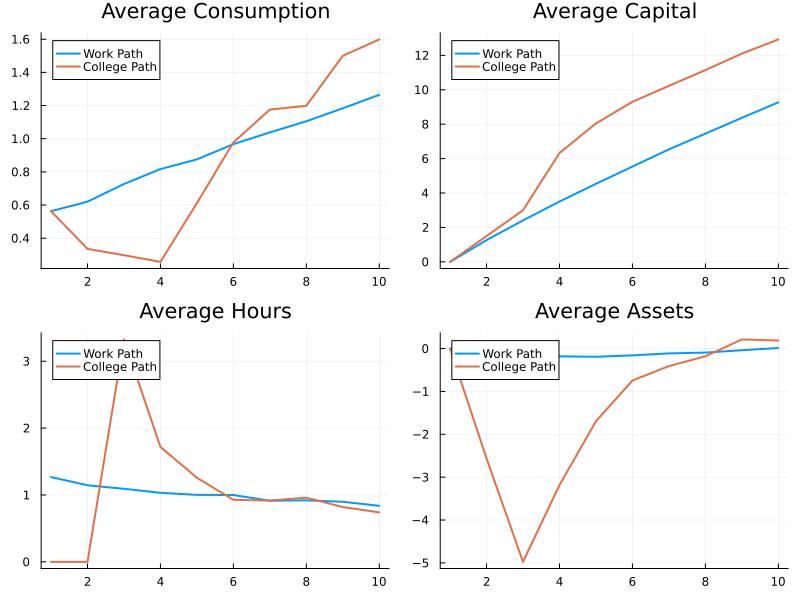

In [ ]:
# Number of agents
N = 1000

# Simulate both paths
c_work, h_work, a_work, k_work = simulate_work_path(model, N)
c_college, h_college, a_college, k_college = simulate_college_path(model, N)

# Compute means across agents
t = 1:model.T
mean_c_work = mean(c_work, dims=1)[:]
mean_c_college = mean(c_college, dims=1)[:]
mean_k_work = mean(k_work, dims=1)[:]
mean_k_college = mean(k_college, dims=1)[:]
mean_h_work = mean(h_work, dims=1)[:]
mean_h_college = mean(h_college, dims=1)[:]
mean_a_work = mean(a_work, dims=1)[:]
mean_a_college = mean(a_college, dims=1)[:]

# Plotting
p1 = plot(t, mean_c_work, label="Work Path", title="Average Consumption", lw=2)
plot!(p1, t, mean_c_college, label="College Path", lw=2)

p2 = plot(t, mean_k_work, label="Work Path", title="Average Capital", lw=2)
plot!(p2, t, mean_k_college, label="College Path", lw=2)

p3 = plot(t, mean_h_work, label="Work Path", title="Average Hours", lw=2)
plot!(p3, t, mean_h_college, label="College Path", lw=2)

p4 = plot(t, mean_a_work, label="Work Path", title="Average Assets", lw=2)
plot!(p4, t, mean_a_college, label="College Path", lw=2)

# Display plots
plot(p1, p2, p3, p4, layout=(2,2), size=(800,600), legend=:topleft)